In [1]:
import pandas as pd
from matplotlib import pyplot as plt

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from matplotlib import pyplot as plt
import matplotlib

import numpy as np

GSPREADHSEET_DOWNLOAD_URL = (
    "https://docs.google.com/spreadsheets/d/{gid}/export?format=csv&id={gid}".format
)
TP_GID = '1-DWTP8uwVS-dZY402-dm0F9ICw_6PNqDGLmH0u8Eqa0'
df = pd.read_csv(GSPREADHSEET_DOWNLOAD_URL(gid=TP_GID))

In [2]:
def feature_engineering(df):
    # Missings en barrio
    data_set_mejorado = df.copy()
    barrios = df['barrio'].dropna()
    cantidad = df['barrio'].isna().value_counts()[True]
    muestra = barrios.sample(cantidad)
    it = iter(muestra)
    data_set_mejorado['barrio'] = data_set_mejorado['barrio'].apply(lambda x: next(it) if str(x) == 'nan' else x)

    # Missings en categoría de trabajo
    data_set_mejorado['categoria_de_trabajo'] = data_set_mejorado['categoria_de_trabajo'].apply(lambda x: 'Sin categoria' if str(x) == 'nan' else x)

    # Missings en trabajo
    data_set_mejorado['trabajo'] = data_set_mejorado['trabajo'].apply(lambda x: 'No responde' if str(x) == 'nan' else x)

    # Eliminación de categoría "sin trabajo"
    data_set_mejorado = data_set_mejorado[data_set_mejorado.categoria_de_trabajo != 'sin_trabajo']

    # Eliminación de el atributo eduación alcanzada
    del data_set_mejorado['educacion_alcanzada']

    # Juntamos casado y casada en una misma categoría.
    data_set_mejorado['rol_familiar_registrado'] = data_set_mejorado['rol_familiar_registrado'].apply(lambda x : 'casado' if x == 'casada' else x)
    
    return data_set_mejorado

In [158]:
df = feature_engineering(df)

# Acciones en bolsa

In [28]:
def designar_accion(x):
    if(x > 7000):
        return "Mucha ganancia"
    elif(x > 0):
        return "Ganancia"
    elif(x == 0):
        return "Nada"
    elif(x > -5000):
        return "Perdida"
    else:
        return "Mucha perdida"

df_tmp = df.copy()
del df_tmp['ganancia_perdida_declarada_bolsa_argentina']
df_tmp['bolsa'] = df['ganancia_perdida_declarada_bolsa_argentina'].apply(designar_accion)

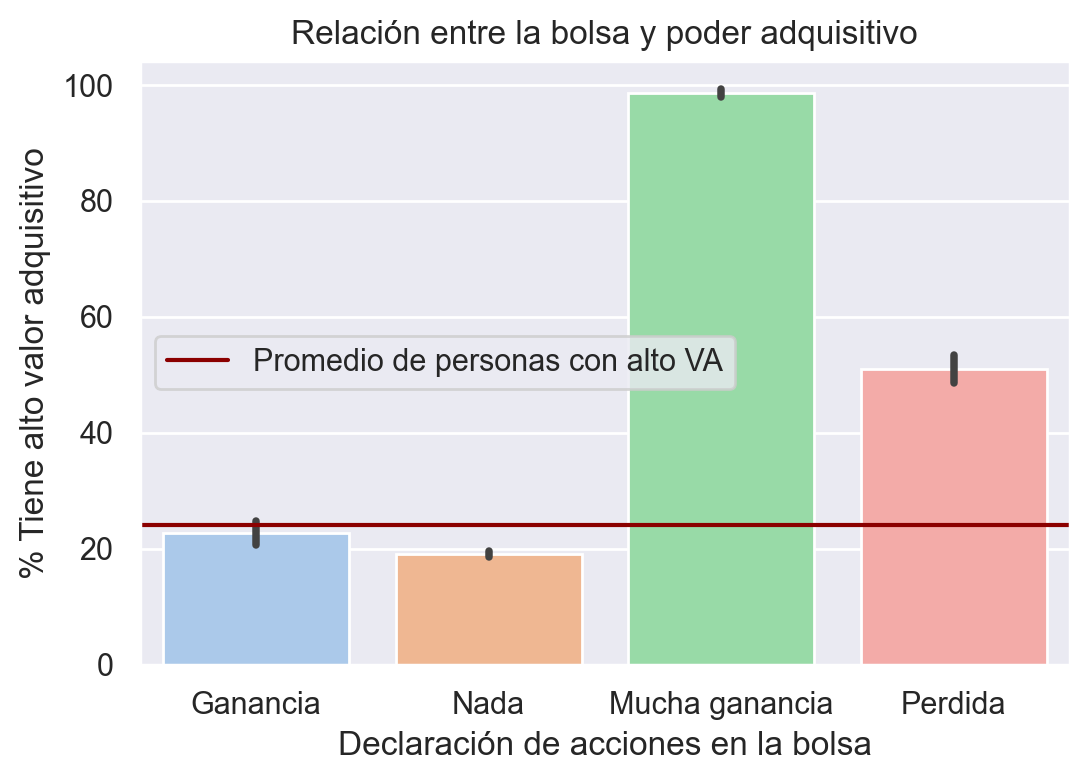

In [29]:
plt.figure(dpi=200)
ax = sns.barplot(
    data=df_tmp,
    palette="pastel",
    x='bolsa',
    y='tiene_alto_valor_adquisitivo',
    estimator=lambda x: np.mean(x)*100.0
)
plt.ylabel("% Tiene alto valor adquisitivo")
plt.xlabel("Declaración de acciones en la bolsa")
plt.title('Relación entre la bolsa y poder adquisitivo')
prom = df['tiene_alto_valor_adquisitivo'].mean()*100.0
plt.axhline(prom, color="darkred", label="Promedio de personas con alto VA")
plt.legend()
plt.show()

# Condicionando por edad

In [159]:
df_tmp = df[df['edad'] < 30].copy()

print(len(df_tmp))
print(np.mean(df_tmp['tiene_alto_valor_adquisitivo'] == 0))

9705
0.9473467284904689


De acá obtenemos la información de que para la gente que tiene menos que 30 años (son alrededor de 9700 personas) con un accuracy del 95% podemos estimar que no tienen poder adquisitivo alto.

In [160]:
df_edad_m30 = df[df['edad'] > 30].copy()

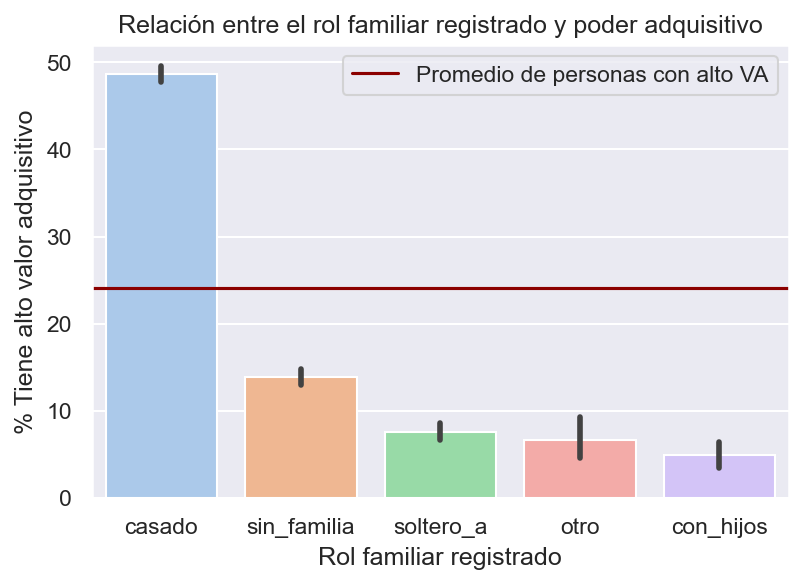

In [161]:
plt.figure(dpi=150)


df_rol_familiar_vs_va = df_edad_m30[['rol_familiar_registrado', 'tiene_alto_valor_adquisitivo']].copy()
orden = df_rol_familiar_vs_va.groupby(['rol_familiar_registrado'])['tiene_alto_valor_adquisitivo'].aggregate(lambda x : np.mean(x)).reset_index().sort_values('tiene_alto_valor_adquisitivo', ascending = False)

ax = sns.barplot(
    data=df_rol_familiar_vs_va,
    palette = "pastel",
    x='rol_familiar_registrado',
    y='tiene_alto_valor_adquisitivo',
    order=orden['rol_familiar_registrado'],
    estimator = lambda x : np.mean(x)*100.0
)

plt.ylabel("% Tiene alto valor adquisitivo")
plt.xlabel("Rol familiar registrado")
plt.title('Relación entre el rol familiar registrado y poder adquisitivo')
prom = df['tiene_alto_valor_adquisitivo'].mean()*100.0
plt.axhline(prom, color="darkred", label="Promedio de personas con alto VA")
plt.legend()
plt.show()

Por lo que, podemos observar que para la gente mayor a 30 años que no está casada la proporción de personas con poder adquisitivo alto es muy baja, veamos cuánto error cometemos en estimarlos como 0.

In [162]:
df_tmp = df_edad_m30[(df_edad_m30['rol_familiar_registrado'] != 'casado') & (df_edad_m30['rol_familiar_registrado'] != 'sin_familia')]

print(len(df_tmp))
print(np.mean(df_tmp['tiene_alto_valor_adquisitivo'] == 0))

4035
0.9313506815365551


In [163]:
df_pipeline = df_edad_m30[(df_edad_m30['rol_familiar_registrado'] == 'casado') | (df_edad_m30['rol_familiar_registrado'] == 'sin_familia')]

In [164]:
def determinar_categoria_en_bolsa(accion_en_bolsa):
    if(accion_en_bolsa > 0):
        return 'Ganancia'
    elif(accion_en_bolsa < 0):
        return 'Pérdida'
    else:
        return 'Nada'

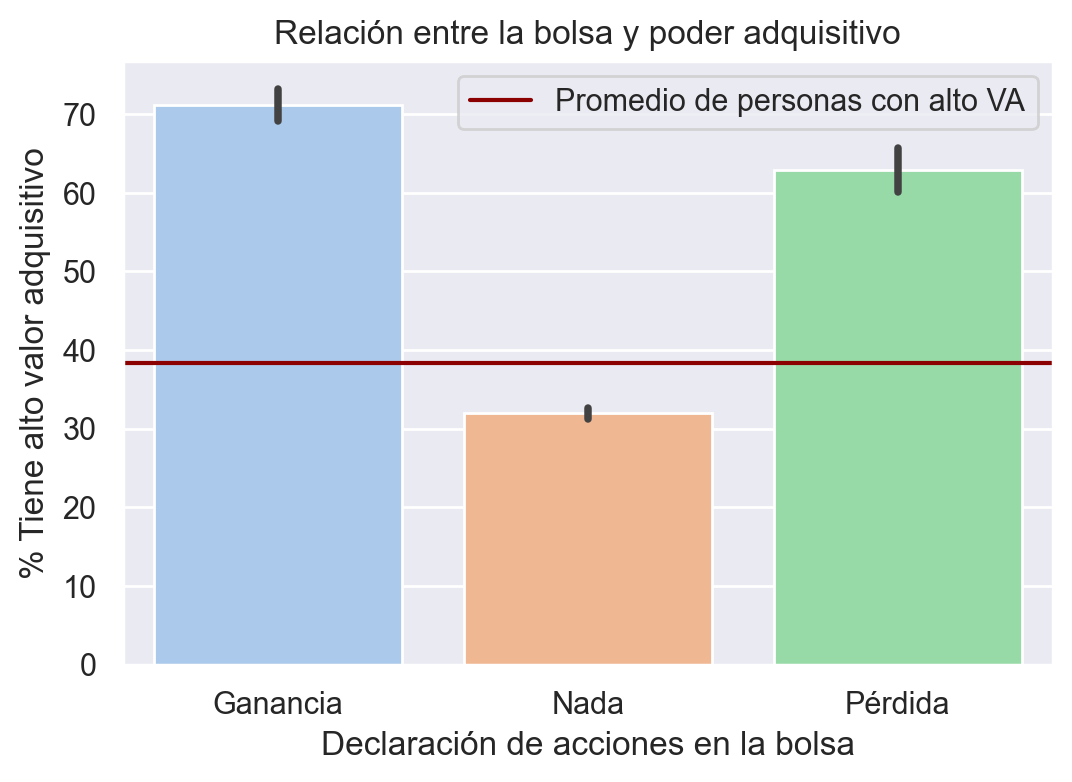

In [165]:
df_bolsa_vs_va = df_pipeline[['ganancia_perdida_declarada_bolsa_argentina', 'tiene_alto_valor_adquisitivo']].copy()
df_bolsa_vs_va['bolsa'] = df_bolsa_vs_va['ganancia_perdida_declarada_bolsa_argentina'].apply(determinar_categoria_en_bolsa)
del df_bolsa_vs_va['ganancia_perdida_declarada_bolsa_argentina']

plt.figure(dpi=200)
ax = sns.barplot(
    data=df_bolsa_vs_va,
    palette="pastel",
    x='bolsa',
    y='tiene_alto_valor_adquisitivo',
    estimator=lambda x: np.mean(x)*100.0
)
plt.ylabel("% Tiene alto valor adquisitivo")
plt.xlabel("Declaración de acciones en la bolsa")
plt.title('Relación entre la bolsa y poder adquisitivo')
prom = df_pipeline['tiene_alto_valor_adquisitivo'].mean()*100.0
plt.axhline(prom, color="darkred", label="Promedio de personas con alto VA")
plt.legend()
plt.show()

Este gráfico no nos copa tanto, ningún barplot nos da un accuracy mayor a un 85% que podemos estimar como bueno

### Años estudidados

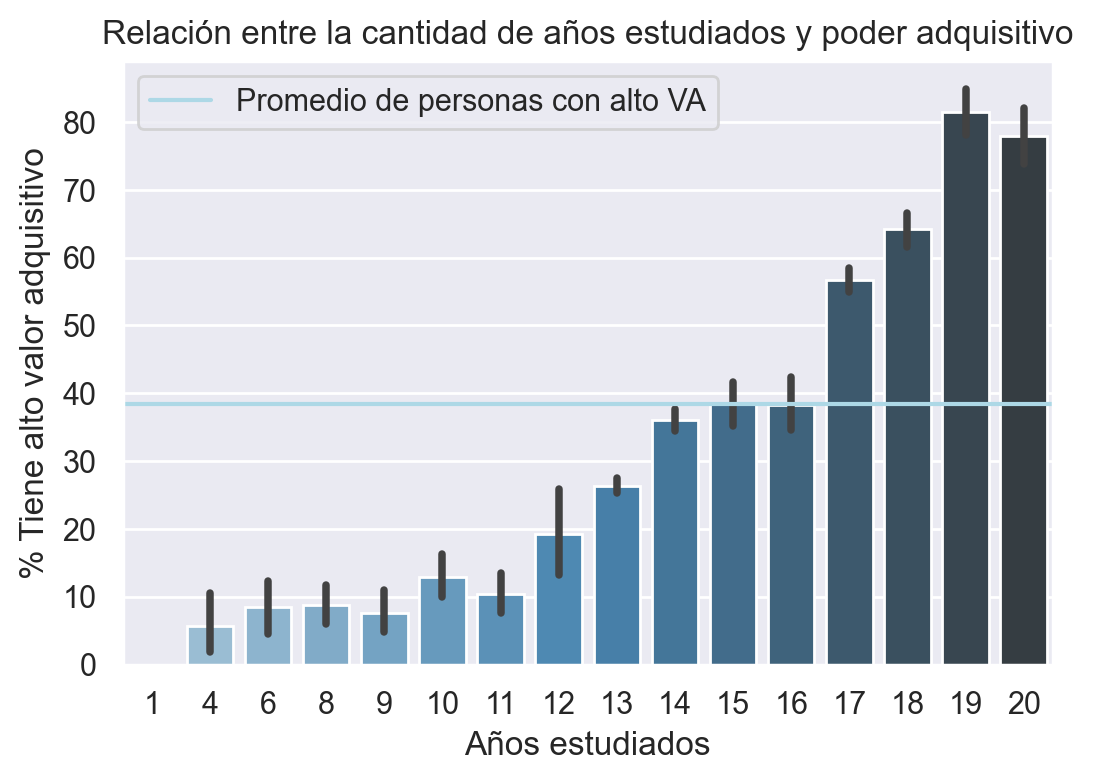

In [166]:
plt.figure(dpi=200)

df_educacion_vs_va = df_pipeline[['anios_estudiados', 'tiene_alto_valor_adquisitivo']].copy()
ax = sns.barplot(
    data=df_educacion_vs_va,
    palette="Blues_d",
    x='anios_estudiados',
    y='tiene_alto_valor_adquisitivo',
    estimator = lambda x: np.mean(x)*100.0
)

plt.ylabel("% Tiene alto valor adquisitivo")
plt.xlabel("Años estudiados")
plt.title('Relación entre la cantidad de años estudiados y poder adquisitivo')
prom = df_pipeline['tiene_alto_valor_adquisitivo'].mean()*100.0
plt.axhline(prom, color="lightblue", label="Promedio de personas con alto VA")
plt.legend()
plt.show()

In [167]:
def por_anios_estudiados(row):
    if(row['anios_estudiados'] <= 11):
        return 0
    else: #(row['anios_estudiados'] >= 19):
        return 1

df_tmp = df_pipeline[(df_pipeline['anios_estudiados'] <= 11) | (df_pipeline['anios_estudiados'] >= 19)]
print(len(df_tmp))
np.mean(df_tmp['tiene_alto_valor_adquisitivo'] == df_tmp.apply(por_anios_estudiados, axis=1))

2691


0.8714232627276105

#### estado martial

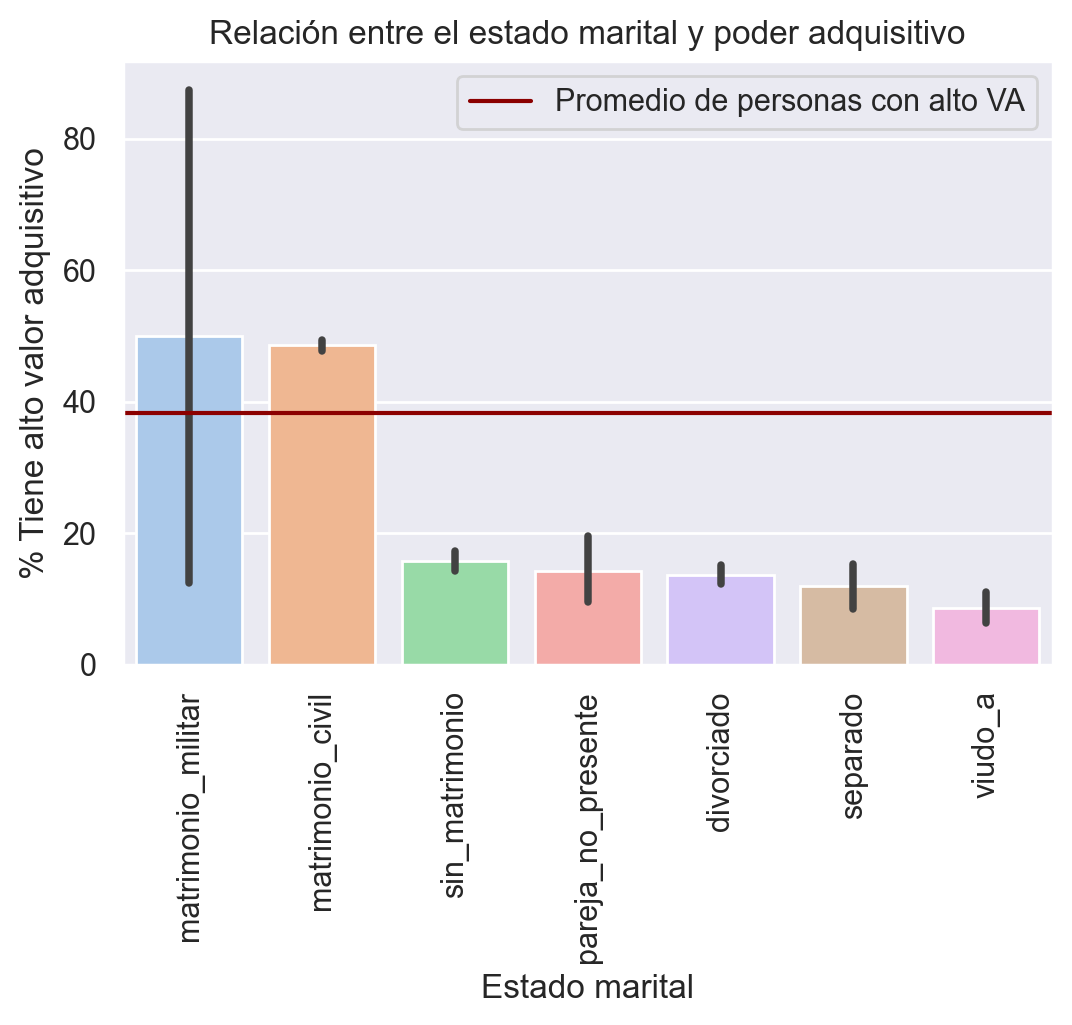

In [168]:
plt.figure(dpi=200)

df_estado_marital_vs_va = df_pipeline[['estado_marital', 'tiene_alto_valor_adquisitivo']].copy()
orden = df_estado_marital_vs_va.groupby(['estado_marital'])['tiene_alto_valor_adquisitivo'].aggregate(lambda x : np.mean(x)).reset_index().sort_values('tiene_alto_valor_adquisitivo', ascending = False)

ax = sns.barplot(
    data=df_estado_marital_vs_va,
    palette = "pastel",
    x='estado_marital',
    y='tiene_alto_valor_adquisitivo',
    order=orden['estado_marital'],
    estimator = lambda x: np.mean(x)*100.0
)

plt.ylabel("% Tiene alto valor adquisitivo")
plt.xlabel("Estado marital")
plt.xticks(rotation=90)
plt.title('Relación entre el estado marital y poder adquisitivo')
prom = df_pipeline['tiene_alto_valor_adquisitivo'].mean()*100.0
plt.axhline(prom, color="darkred", label="Promedio de personas con alto VA")
plt.legend()
plt.show()

In [169]:
df_tmp = df_pipeline[df_pipeline['estado_marital'] != 'matrimonio_civil']
print(len(df_tmp))
print(np.mean(df_tmp['tiene_alto_valor_adquisitivo'] == 0))

5324
0.8606311044327574


Nos quedamos con la partición de estado marital

In [170]:
df_pipeline = df_pipeline[df_pipeline['estado_marital'] == 'matrimonio_civil']

In [171]:
df_pipeline

,anios_estudiados,barrio,categoria_de_trabajo,edad,estado_marital,ganancia_perdida_declarada_bolsa_argentina,genero,horas_trabajo_registradas,religion,rol_familiar_registrado,tiene_alto_valor_adquisitivo,trabajo
1,17,Palermo,monotibutista,50,matrimonio_civil,0,hombre,13,cristianismo,casado,0,directivo_gerente
3,11,Palermo,relacion_de_dependencia,53,matrimonio_civil,0,hombre,40,judaismo,casado,0,limpiador
5,18,Palermo,relacion_de_dependencia,37,matrimonio_civil,0,mujer,40,cristianismo,casado,0,directivo_gerente
7,13,Palermo,monotibutista,52,matrimonio_civil,0,hombre,45,cristianismo,casado,1,directivo_gerente
9,17,Palermo,relacion_de_dependencia,42,matrimonio_civil,5178,hombre,40,cristianismo,casado,1,directivo_gerente
...,...,...,...,...,...,...,...,...,...,...,...,...
32551,10,Palermo,relacion_de_dependencia,32,matrimonio_civil,0,hombre,40,ateismo,casado,0,limpiador
32552,15,Palermo,relacion_de_dependencia,43,matrimonio_civil,0,hombre,45,cristianismo,casado,0,ventas
32554,18,Palermo,relacion_de_dependencia,53,matrimonio_civil,0,hombre,40,cristianismo,casado,1,directivo_gerente
32557,13,Palermo,relacion_de_dependencia,40,matrimonio_civil,0,hombre,40,cristianismo,casado,1,inspector


In [172]:
cant = 20

tabla = df_pipeline['barrio'].value_counts()
barrios_significativos = tabla[tabla > cant].reset_index()['index'].unique()

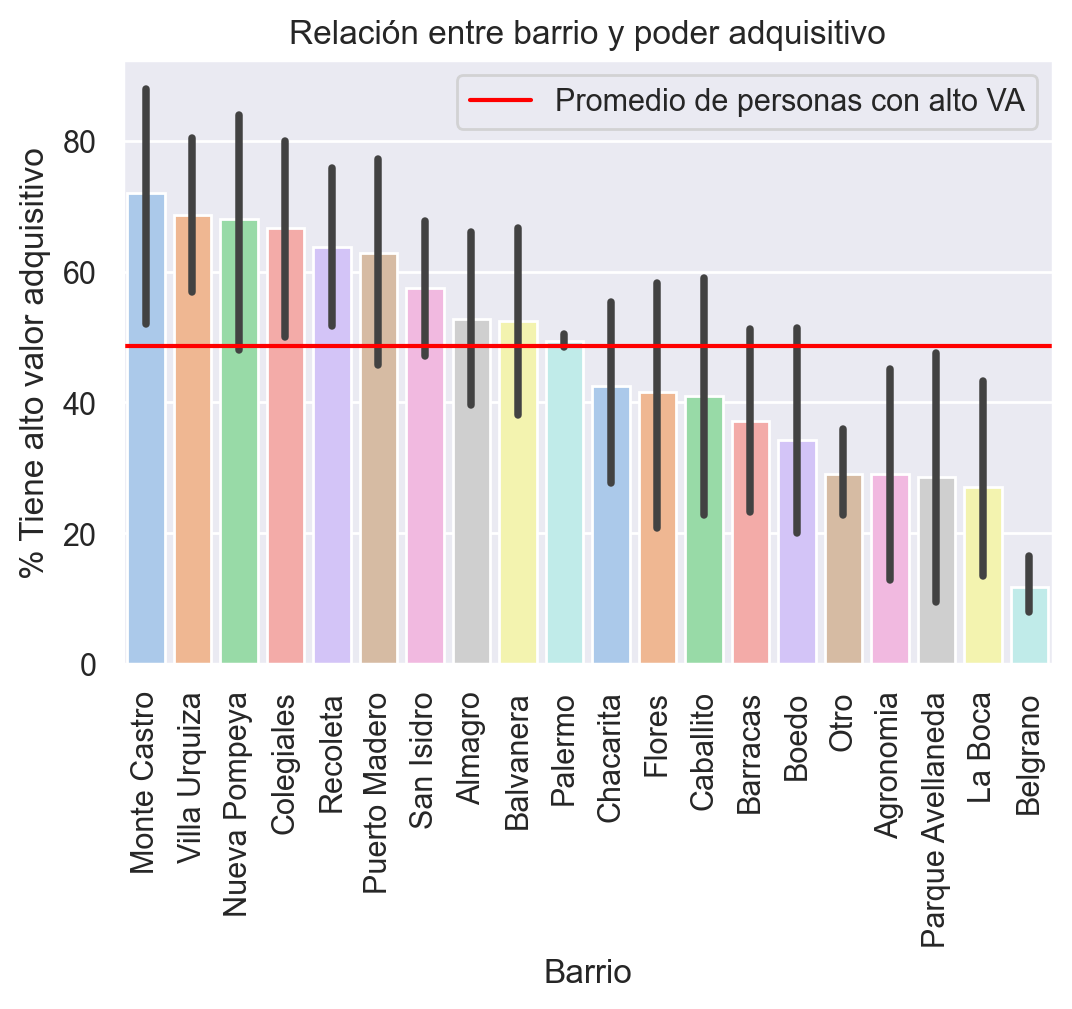

In [173]:
plt.figure(dpi=200)


df_barrio_vs_va = df_pipeline[['barrio', 'tiene_alto_valor_adquisitivo']].copy()
df_barrio_vs_va['barrio'] = df_barrio_vs_va['barrio'].apply(lambda x: x if x in barrios_significativos else 'Otro')
orden = df_barrio_vs_va.groupby(['barrio'])['tiene_alto_valor_adquisitivo'].aggregate(lambda x : np.mean(x)).reset_index().sort_values('tiene_alto_valor_adquisitivo', ascending = False)

ax = sns.barplot(
    data=df_barrio_vs_va,
    palette="pastel",
    x='barrio',
    y='tiene_alto_valor_adquisitivo',
    order=orden['barrio'],
    estimator=lambda x: np.mean(x)*100.0
)

plt.ylabel("% Tiene alto valor adquisitivo")
plt.xlabel("Barrio")
plt.xticks(rotation=90)
plt.title('Relación entre barrio y poder adquisitivo')
prom = df_pipeline['tiene_alto_valor_adquisitivo'].mean()*100.0
plt.axhline(prom, color="red", label="Promedio de personas con alto VA")
plt.legend()
plt.show()

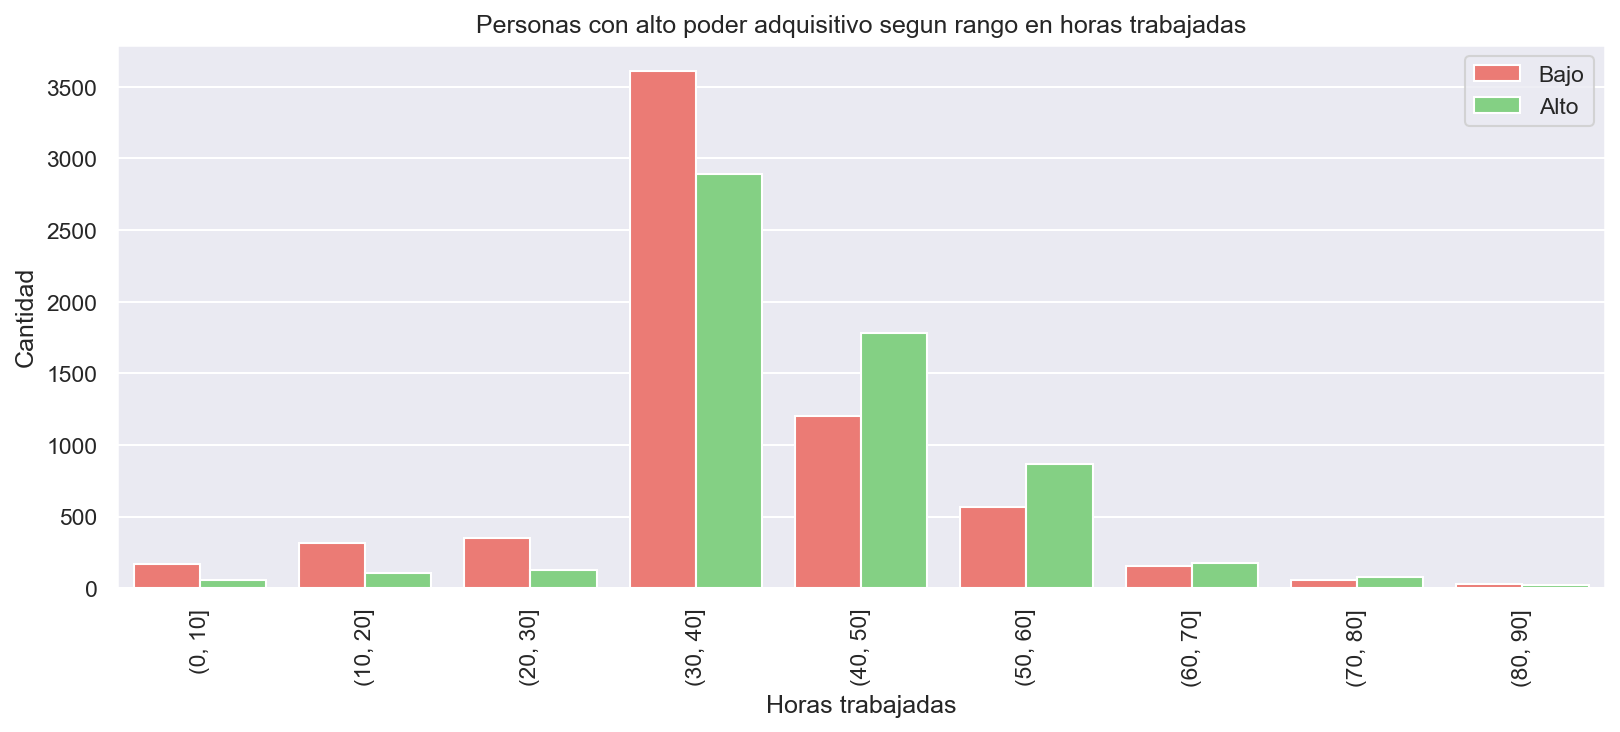

In [174]:
df_tmp = pd.DataFrame([df_pipeline.horas_trabajo_registradas,df_pipeline.tiene_alto_valor_adquisitivo]).transpose()
df_tmp['bins'] = pd.cut(df_tmp.horas_trabajo_registradas, range(0, 100, 10)) # ver si 10 o 5 el tamaño
# Configuro el grafico, armo el countplot y setteo labels varios
fig, ax = plt.subplots(dpi=150, figsize=(6.4 * 2, 4.8))
sns.countplot(data = df_tmp, x = 'bins', hue='tiene_alto_valor_adquisitivo', ax = ax, palette = ['#ff6961', '#77dd77'])
ax.set_title('Personas con alto poder adquisitivo segun rango en horas trabajadas')
ax.set_xlabel('Horas trabajadas')
plt.xticks(rotation=90)
ax.set_ylabel('Cantidad')
plt.legend(['Bajo', 'Alto'], loc='upper right')
plt.show()

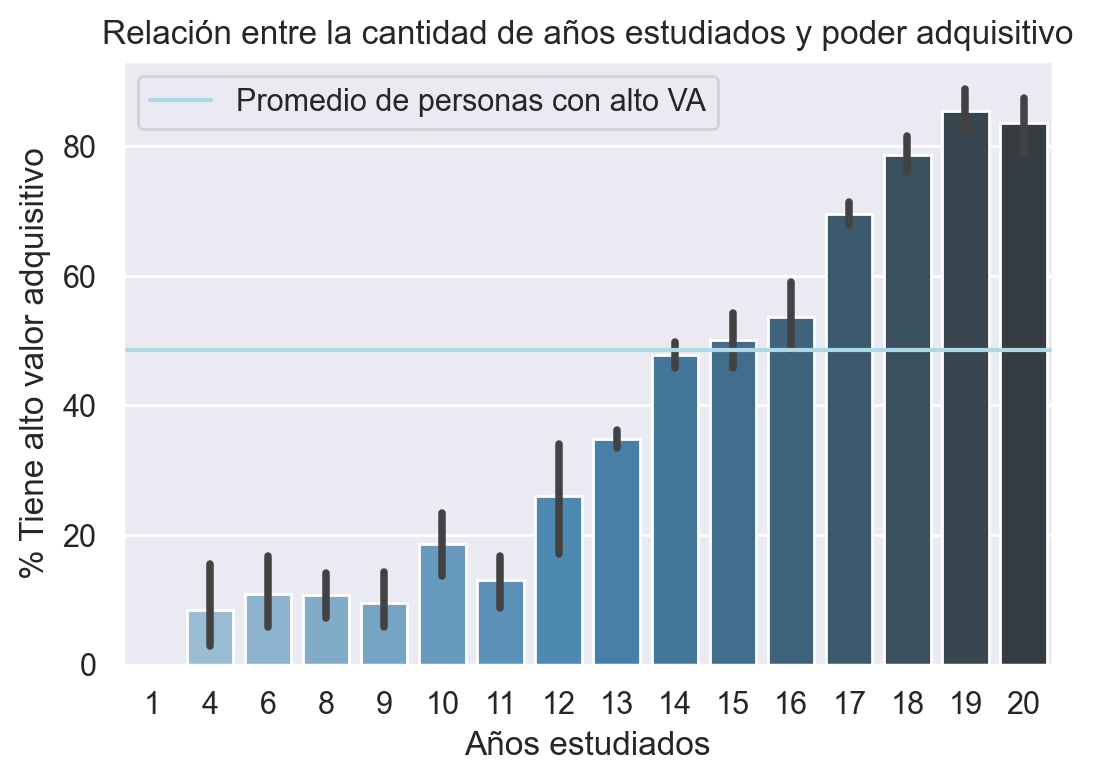

In [175]:
plt.figure(dpi=200)

df_educacion_vs_va = df_pipeline[['anios_estudiados', 'tiene_alto_valor_adquisitivo']].copy()
ax = sns.barplot(
    data=df_educacion_vs_va,
    palette="Blues_d",
    x='anios_estudiados',
    y='tiene_alto_valor_adquisitivo',
    estimator = lambda x: np.mean(x)*100.0
)

plt.ylabel("% Tiene alto valor adquisitivo")
plt.xlabel("Años estudiados")
plt.title('Relación entre la cantidad de años estudiados y poder adquisitivo')
prom = df_pipeline['tiene_alto_valor_adquisitivo'].mean()*100.0
plt.axhline(prom, color="lightblue", label="Promedio de personas con alto VA")
plt.legend()
plt.show()

In [176]:
len(df_pipeline[df_pipeline['anios_estudiados'] >= 18])

1606

##### por bolsa

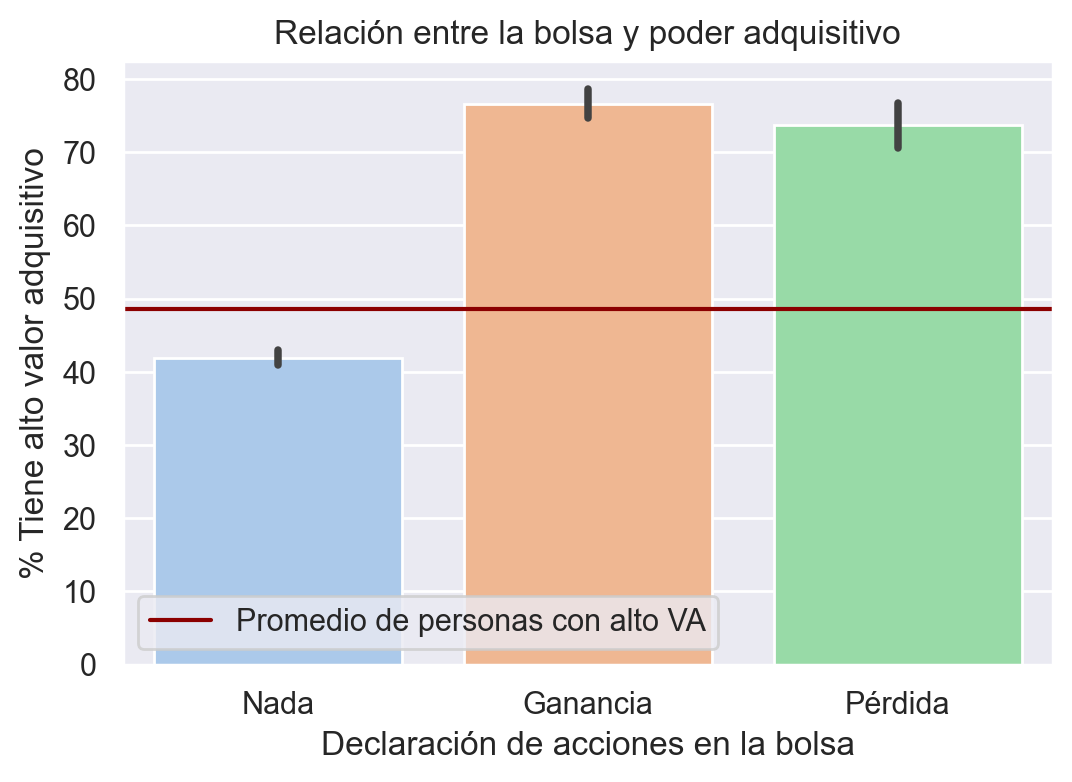

In [177]:
df_bolsa_vs_va = df_pipeline[['ganancia_perdida_declarada_bolsa_argentina', 'tiene_alto_valor_adquisitivo']].copy()
df_bolsa_vs_va['bolsa'] = df_bolsa_vs_va['ganancia_perdida_declarada_bolsa_argentina'].apply(determinar_categoria_en_bolsa)
del df_bolsa_vs_va['ganancia_perdida_declarada_bolsa_argentina']

plt.figure(dpi=200)
ax = sns.barplot(
    data=df_bolsa_vs_va,
    palette="pastel",
    x='bolsa',
    y='tiene_alto_valor_adquisitivo',
    estimator=lambda x: np.mean(x)*100.0
)
plt.ylabel("% Tiene alto valor adquisitivo")
plt.xlabel("Declaración de acciones en la bolsa")
plt.title('Relación entre la bolsa y poder adquisitivo')
prom = df_pipeline['tiene_alto_valor_adquisitivo'].mean()*100.0
plt.axhline(prom, color="darkred", label="Promedio de personas con alto VA")
plt.legend()
plt.show()

In [178]:
df_tmp = df_pipeline[df_pipeline['ganancia_perdida_declarada_bolsa_argentina'] != 0]

print(len(df_tmp))
print(np.mean(df_tmp['tiene_alto_valor_adquisitivo'] == 1))

2501
0.7564974010395842


In [179]:
df_pipeline = df_pipeline[df_pipeline['ganancia_perdida_declarada_bolsa_argentina'] == 0]
df_pipeline

,anios_estudiados,barrio,categoria_de_trabajo,edad,estado_marital,ganancia_perdida_declarada_bolsa_argentina,genero,horas_trabajo_registradas,religion,rol_familiar_registrado,tiene_alto_valor_adquisitivo,trabajo
1,17,Palermo,monotibutista,50,matrimonio_civil,0,hombre,13,cristianismo,casado,0,directivo_gerente
3,11,Palermo,relacion_de_dependencia,53,matrimonio_civil,0,hombre,40,judaismo,casado,0,limpiador
5,18,Palermo,relacion_de_dependencia,37,matrimonio_civil,0,mujer,40,cristianismo,casado,0,directivo_gerente
7,13,Palermo,monotibutista,52,matrimonio_civil,0,hombre,45,cristianismo,casado,1,directivo_gerente
10,14,Palermo,relacion_de_dependencia,37,matrimonio_civil,0,hombre,80,judaismo,casado,1,directivo_gerente
...,...,...,...,...,...,...,...,...,...,...,...,...
32550,14,Palermo,monotibutista,43,matrimonio_civil,0,hombre,50,cristianismo,casado,0,reparador
32551,10,Palermo,relacion_de_dependencia,32,matrimonio_civil,0,hombre,40,ateismo,casado,0,limpiador
32552,15,Palermo,relacion_de_dependencia,43,matrimonio_civil,0,hombre,45,cristianismo,casado,0,ventas
32554,18,Palermo,relacion_de_dependencia,53,matrimonio_civil,0,hombre,40,cristianismo,casado,1,directivo_gerente


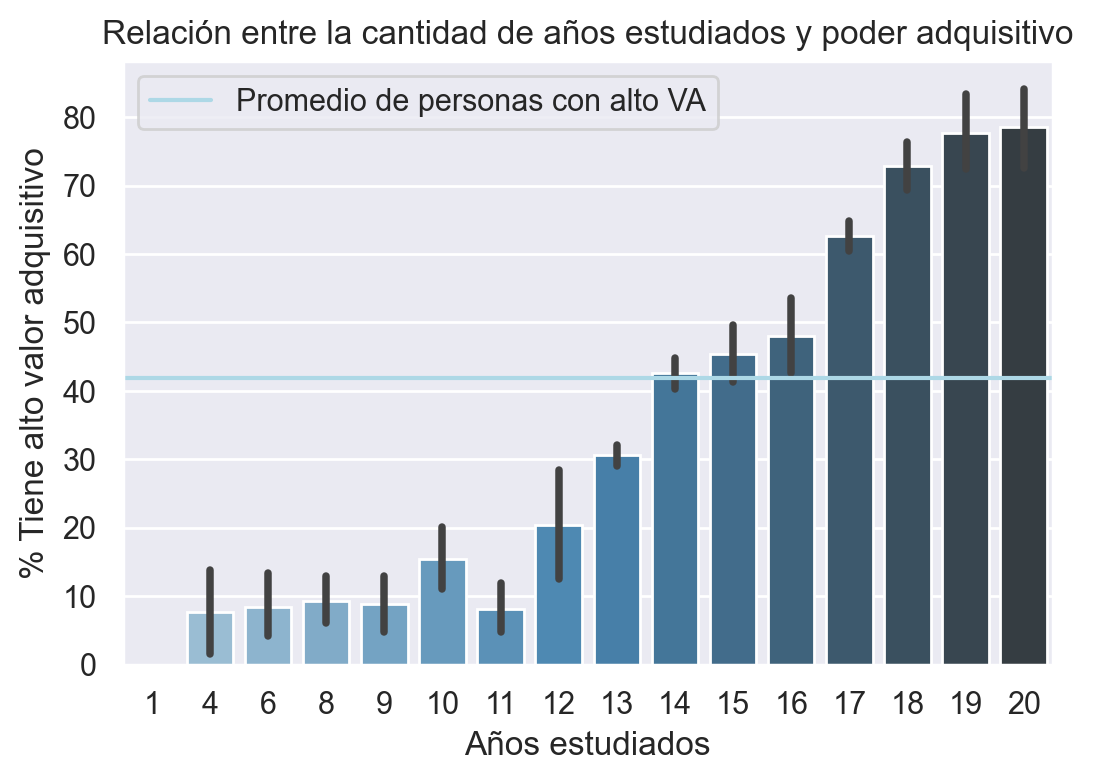

In [180]:
plt.figure(dpi=200)

df_educacion_vs_va = df_pipeline[['anios_estudiados', 'tiene_alto_valor_adquisitivo']].copy()
ax = sns.barplot(
    data=df_educacion_vs_va,
    palette="Blues_d",
    x='anios_estudiados',
    y='tiene_alto_valor_adquisitivo',
    estimator = lambda x: np.mean(x)*100.0
)

plt.ylabel("% Tiene alto valor adquisitivo")
plt.xlabel("Años estudiados")
plt.title('Relación entre la cantidad de años estudiados y poder adquisitivo')
prom = df_pipeline['tiene_alto_valor_adquisitivo'].mean()*100.0
plt.axhline(prom, color="lightblue", label="Promedio de personas con alto VA")
plt.legend()

plt.show()

In [181]:
def ultima_f(row):
    if(row['anios_estudiados'] >= 17):
        return 1
    else:
        return 0

df_tmp = df_pipeline.copy()

print(len(df_tmp))
print(np.mean(df_tmp['tiene_alto_valor_adquisitivo'] == df_tmp.apply(ultima_f, axis=1)))

10129
0.6773620298153816


In [37]:
def baseline(row):
    if(row['ganancia_perdida_declarada_bolsa_argentina'] > 7000):
        return 1
    if(row['edad'] < 30):
        return 0
    else:
        if(row['rol_familiar_registrado'] != 'casado'):
            return 0
        else:
            if(row['anios_estudiados'] >= 17):
                return 1
            else:
                return 0


np.mean(df['tiene_alto_valor_adquisitivo'] == df.apply(baseline, axis=1))

0.8387027425447622

In [38]:
df_0 = df[df['tiene_alto_valor_adquisitivo'] == 0].copy()
np.mean(df_0['tiene_alto_valor_adquisitivo'] == df_0.apply(baseline, axis=1))

0.9605177993527508

In [39]:
df_1 = df[df['tiene_alto_valor_adquisitivo'] == 1].copy()
np.mean(df_1['tiene_alto_valor_adquisitivo'] == df_1.apply(baseline, axis=1))

0.4546613952302002

In [ ]:
df_tmp = df[() & () & (df['rol_familiar_registrado'] != 'casado') & ]
np.mean(df_tmp)

In [222]:
def bolsita(x):
    if(x > 7000):
        return "Mucha ganancia"
    elif(x > 0):
        return "Ganancia"
    elif(x == 0):
        return "Nada"
    elif(x > -5000):
        return "Perdida"
    else:
        return "Mucha perdida"

df_tmp = df.copy()
del df_tmp['ganancia_perdida_declarada_bolsa_argentina']
df_tmp['bolsa'] = df['ganancia_perdida_declarada_bolsa_argentina'].apply(bolsita)

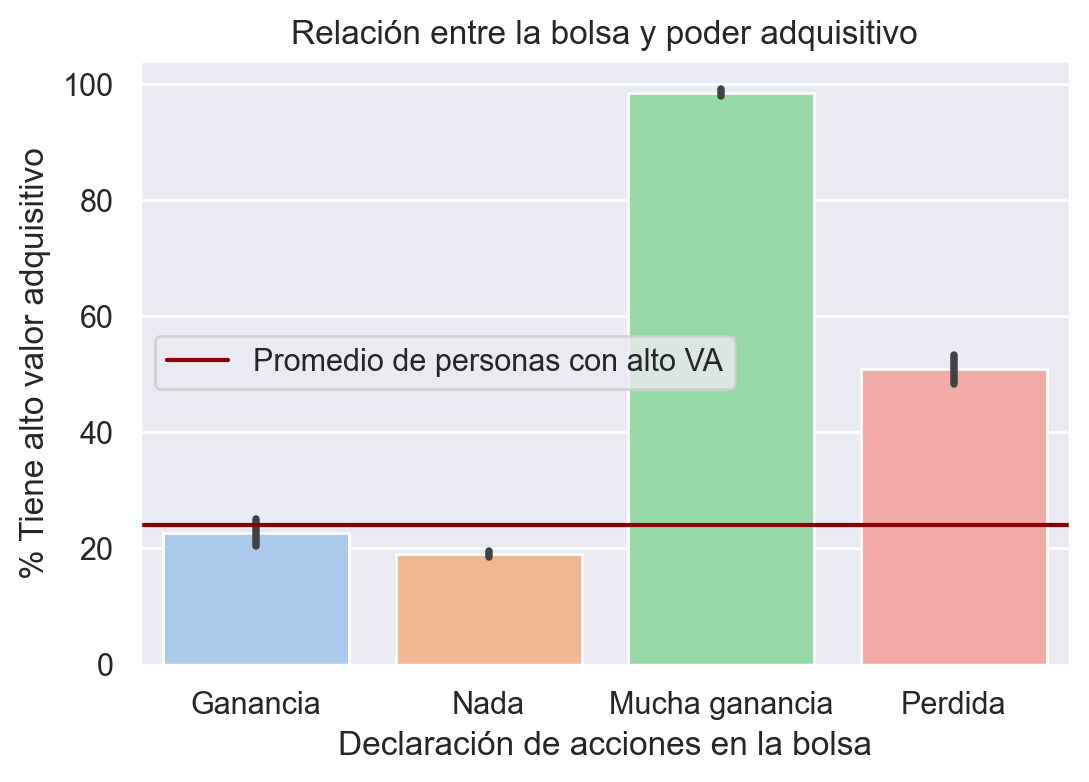

In [223]:
plt.figure(dpi=200)
ax = sns.barplot(
    data=df_tmp,
    palette="pastel",
    x='bolsa',
    y='tiene_alto_valor_adquisitivo',
    estimator=lambda x: np.mean(x)*100.0
)
plt.ylabel("% Tiene alto valor adquisitivo")
plt.xlabel("Declaración de acciones en la bolsa")
plt.title('Relación entre la bolsa y poder adquisitivo')
prom = df['tiene_alto_valor_adquisitivo'].mean()*100.0
plt.axhline(prom, color="darkred", label="Promedio de personas con alto VA")
plt.legend()
plt.show()

In [190]:
df_tmp['bolsa'].value_counts()

Nada              28323
Mucha ganancia     1648
Perdida            1519
Ganancia           1064
Name: bolsa, dtype: int64

In [191]:
df['tiene_alto_valor_adquisitivo'].value_counts()

0    24713
1     7841
Name: tiene_alto_valor_adquisitivo, dtype: int64